<a href="https://colab.research.google.com/github/RadhavaramHarika/Harika_INFO5731_Spring2020/blob/master/Harika_INFO5731_Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [130]:
# Write your code here
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import pandas as panda
import re
import numpy as nump
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plot
%matplotlib inline

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Initialize spacy 'en' model
nlp = spacy.load('en', disable=['parser', 'ner'])

#Using Functions to get input data and preprocess using gensim
def getReviews(filepath):
  name = ["Total_Reviews"]
  data = panda.read_csv(filepath,usecols = [2],names=name)
  return data.Total_Reviews.values.tolist()[1:]

def tokenization(ReviewsList):
    for sentence in ReviewsList:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def stopwords_removal(reviewTokens):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in reviewTokens]

def build_bigrams_model(reviewTokensList):
  bigram = gensim.models.Phrases(reviewTokensList, min_count=5, threshold=100)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  return (bigram,bigram_mod)

def build_trigrams_model(reviewTokensList,bigrms):
  trigram = gensim.models.Phrases(bigrms[reviewTokensList], threshold=100)  
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  return trigram_mod

def reviews_bigrams(reviewTokens,model):
  return [model[doc] for doc in reviewTokens]

def reviews_trigrams(reviewTokens,bgrm_mod,tgrm_mod):
  return [tgrm_mod[bgrm_mod[doc]] for doc in reviewTokens]

def reviews_lemmatization(reviewTokens, allowed_pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    review_lemmas = []
    for tokens in reviewTokens:
        doc = nlp(" ".join(tokens)) 
        review_lemmas.append([token.lemma_ for token in doc if token.pos_ in allowed_pos])
    return review_lemmas


#calling above functions to get the input data and get preprocessed tokens with lemmatization
inputPath = "https://raw.githubusercontent.com/RadhavaramHarika/Harika_INFO5731_Spring2020/master/UserReview.csv"
reviews_data = getReviews(inputPath)

reviews_tokens = list(tokenization(reviews_data))

bi_grams_model = build_bigrams_model(reviews_tokens)

tri_gram_model = build_trigrams_model(reviews_tokens,bi_grams_model[0])

reviews_nostops = stopwords_removal(reviews_tokens)

reviews_bigram_words = reviews_bigrams(reviews_nostops,bi_grams_model[1])

lemmatized_reviews = reviews_lemmatization(reviews_bigram_words, allowed_pos=['NOUN', 'ADJ', 'VERB', 'ADV'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


# **above code takes input data and cleans it using gensim**

In [6]:
#Using function to create dictionary for Topic Model
def dict_corpus(reviews_lemmas):
  id2word = corpora.Dictionary(reviews_lemmas)
  corpus = [id2word.doc2bow(review) for review in reviews_lemmas]
  return id2word,corpus

#Calling above function to create Dictionary and term frequencies
rev_dict, corpus =  dict_corpus(lemmatized_reviews)

print("Term frequencies in first Review:\n")
[[(rev_dict[id], freq) for id, freq in cp] for cp in corpus[:1]]


Term frequencies in first Review:



[[('achievement', 1),
  ('act', 1),
  ('age', 1),
  ('audience', 1),
  ('awestruck', 1),
  ('base', 1),
  ('believe', 1),
  ('best', 1),
  ('bit', 1),
  ('bleak', 1),
  ('bleed', 1),
  ('blow', 1),
  ('brilliant', 1),
  ('cgi', 1),
  ('character', 1),
  ('cinema', 1),
  ('claim', 1),
  ('comic', 1),
  ('could', 1),
  ('cry', 1),
  ('day', 1),
  ('dedicated', 1),
  ('direct', 1),
  ('drop', 1),
  ('echo', 1),
  ('even', 1),
  ('excitement', 1),
  ('existence', 1),
  ('extremely', 1),
  ('film', 3),
  ('finish', 1),
  ('go', 1),
  ('good', 1),
  ('great', 1),
  ('hype', 1),
  ('impeccable', 1),
  ('incredibly', 1),
  ('joker', 1),
  ('look', 1),
  ('magnificently', 1),
  ('massive', 1),
  ('masterpiece', 2),
  ('member', 1),
  ('nonsense', 1),
  ('origin', 1),
  ('overblown', 1),
  ('overreact', 1),
  ('palpable', 1),
  ('performance', 2),
  ('person', 1),
  ('place', 1),
  ('pretentious', 1),
  ('proud', 1),
  ('rare', 1),
  ('reboot', 2),
  ('revere', 1),
  ('say', 1),
  ('see', 1),
  

In [7]:
from gensim.models import LdaModel

#Using function to generate LDA model with 10 topics using gensim
def create_gensim_lda_model(number_of_topics,words):
  lda_model = LdaModel(corpus,num_topics=number_of_topics,id2word=rev_dict,passes=20,chunksize = 100)
  print(lda_model.print_topics(num_topics=number_of_topics, num_words=10))
  return lda_model

#Calling above function to get lda model instance for our corpus
lda_model1 = create_gensim_lda_model(10,10)
print("10 Topics:\n")
lda_model1.show_topics(formatted=False)



[(0, '0.083*"movie" + 0.016*"character" + 0.014*"see" + 0.013*"joker" + 0.012*"go" + 0.011*"good" + 0.011*"make" + 0.011*"think" + 0.010*"action" + 0.010*"performance"'), (1, '0.035*"movie" + 0.023*"story" + 0.021*"take" + 0.019*"film" + 0.019*"mean" + 0.017*"go" + 0.017*"good" + 0.013*"ever" + 0.013*"hand" + 0.012*"point"'), (2, '0.026*"movie" + 0.020*"joker" + 0.018*"great" + 0.015*"story" + 0.013*"would" + 0.013*"perfect" + 0.013*"show" + 0.012*"cinematography" + 0.012*"take" + 0.011*"people"'), (3, '0.014*"reboot" + 0.008*"tone" + 0.008*"bleak" + 0.008*"finish" + 0.008*"bleed" + 0.008*"solid" + 0.008*"excitement" + 0.008*"sweat" + 0.008*"pretentious" + 0.008*"overreact"'), (4, '0.038*"film" + 0.023*"movie" + 0.018*"watch" + 0.017*"see" + 0.016*"good" + 0.014*"people" + 0.014*"plot" + 0.013*"feel" + 0.012*"think" + 0.010*"performance"'), (5, '0.017*"movie" + 0.017*"scene" + 0.014*"film" + 0.014*"make" + 0.012*"go" + 0.012*"portray" + 0.012*"real" + 0.012*"become" + 0.010*"performanc

[(0,
  [('movie', 0.0831329),
   ('character', 0.015682457),
   ('see', 0.01401696),
   ('joker', 0.013180401),
   ('go', 0.012207803),
   ('good', 0.011480912),
   ('make', 0.01067853),
   ('think', 0.010572612),
   ('action', 0.010173483),
   ('performance', 0.010006964)]),
 (1,
  [('movie', 0.035319455),
   ('story', 0.022696063),
   ('take', 0.020585313),
   ('film', 0.01871902),
   ('mean', 0.01871861),
   ('go', 0.017369837),
   ('good', 0.016660612),
   ('ever', 0.012546362),
   ('hand', 0.012546063),
   ('point', 0.012146392)]),
 (2,
  [('movie', 0.025605623),
   ('joker', 0.020449245),
   ('great', 0.017704986),
   ('story', 0.014903583),
   ('would', 0.013427366),
   ('perfect', 0.0134266885),
   ('show', 0.013426517),
   ('cinematography', 0.011951048),
   ('take', 0.011881369),
   ('people', 0.011234345)]),
 (3,
  [('reboot', 0.014451778),
   ('tone', 0.007620458),
   ('bleak', 0.0076202555),
   ('finish', 0.007618527),
   ('bleed', 0.0076097515),
   ('solid', 0.007609729),

# **The above out show the 10 Topics we selected and as we selected number of words (n-grams) in topic as '10',the out here shows ten words in each topic and their contribution in percentage to that topic**

In [8]:
print('\nPerplexity of above LDA Model: ', lda_model1.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model1, texts=lemmatized_reviews, dictionary=rev_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score on above LDA Model: ', coherence_lda)


Perplexity of above LDA Model:  -6.273290210797705

Coherence Score on above LDA Model:  0.38521686223670076


# **From coherence score we can say that above LDA model is the semantic similarity of this topic model with 10 topics is 0.38521 (38.52 % apx)**

In [9]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model1, corpus, rev_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.078786 -0.030665       1        1  23.281076
0      0.104025 -0.027147       2        1  18.688463
6     -0.028786  0.148330       3        1  14.555378
7      0.111959 -0.106740       4        1  14.073885
5     -0.187774 -0.158393       5        1   8.368094
2      0.066341 -0.008509       6        1   7.640862
8      0.030831  0.006914       7        1   6.184051
1      0.014123  0.080599       8        1   5.053139
9     -0.089995  0.046808       9        1   1.683320
3     -0.099511  0.048803      10        1   0.471733, topic_info=              Term        Freq       Total Category  logprob  loglift
29            film  114.000000  114.000000  Default  30.0000  30.0000
95           movie  292.000000  292.000000  Default  29.0000  29.0000
92            make   65.000000   65.000000  Default  28.0000  28.0000
242          story   42.000000   42.000000  Default  27.0000  27.0000
33           great   43.000000   43.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
39   magnificently    0.024251    1.687693  Topic10  -7.2555   1.1139
53            rare    0.024078    1.688197  Topic10  -7.2627   1.1064
36      incredibly    0.024058    1.688251  Topic10  -7.2635   1.1055
22          direct    0.024239    6.826878  Topic10  -7.2560  -0.2842
29            film    0.024170  114.565750  Topic10  -7.2589  -3.1073

[632 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
356       2  0.656766         able
356       8  0.262706         able
1148      5  0.921578        abuse
0         1  0.246285  achievement
0         7  0.492570  achievement
...     ...       ...          ...
77        1  0.963557        write
355       1  0.653470         year
355       3  0.150801         year
355       4  0.150801         year
355       8  0.050267         year

[953 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 7, 8, 6, 3, 9, 2, 10, 4])

# **In this Visulaization, each bubble represents a topic and bigger the size of the bubble then that topic is more prevalent.**

# **When we move cursor on any bubble, the right side plot shos all the terms/words that formed that topic with their overall term frequency in corpus in blue and the term frequency in this selected topic is in red. **

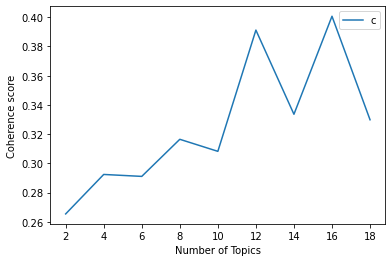

Num Topics = 2  has Coherence Value of 0.2654
Num Topics = 4  has Coherence Value of 0.2924
Num Topics = 6  has Coherence Value of 0.2911
Num Topics = 8  has Coherence Value of 0.3164
Num Topics = 10  has Coherence Value of 0.3082
Num Topics = 12  has Coherence Value of 0.3912
Num Topics = 14  has Coherence Value of 0.3336
Num Topics = 16  has Coherence Value of 0.4007
Num Topics = 18  has Coherence Value of 0.3298
LdaModel(num_terms=1201, num_topics=16, decay=0.5, chunksize=100) 0.40066914748128135


In [10]:
def compute_coherence_values(dictionary, corpus, clean_doc, start,stop):
  coherence_values = []
  model_list = []
  for num_topics in range(start, stop,2):
      # generate LSA model
      model = LdaModel(corpus, num_topics=num_topics, id2word = dictionary,chunksize =100,passes =20)  # train model
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=clean_doc, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())
  return model_list, coherence_values

def plot_graph(clean_doc,start, stop):
  model_list, coherence_values = compute_coherence_values(rev_dict, corpus,clean_doc, start,stop)

  x = range(start, stop, 2)
  plot.plot(x, coherence_values)
  plot.xlabel("Number of Topics")
  plot.ylabel("Coherence score")
  plot.legend(("coherence_values"), loc='best')
  plot.show()

  for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
  indx = coherence_values.index(max(coherence_values))
  print(model_list[indx],coherence_values[indx])

  return (model_list[indx],coherence_values[indx])

optimal_model = plot_graph(lemmatized_reviews,2,20)



# **To get an optimized topic model this plot is drawn and from this the topic model LDA instance that has maximum coherence is selected **



In [11]:
optimal_model[0].show_topics(formatted = True)


[(7,
  '0.037*"good" + 0.024*"time" + 0.019*"seriously" + 0.018*"say" + 0.014*"movie" + 0.014*"watch" + 0.014*"actor" + 0.014*"well" + 0.014*"oscar" + 0.014*"least"'),
 (2,
  '0.058*"movie" + 0.028*"feel" + 0.021*"make" + 0.018*"good" + 0.015*"cinematography" + 0.015*"performance" + 0.015*"plot" + 0.012*"think" + 0.012*"people" + 0.012*"lot"'),
 (5,
  '0.024*"movie" + 0.018*"character" + 0.018*"go" + 0.018*"point" + 0.018*"different" + 0.018*"edge" + 0.018*"critic" + 0.018*"seat" + 0.012*"see" + 0.012*"time"'),
 (13,
  '0.023*"movie" + 0.023*"scene" + 0.017*"go" + 0.017*"real" + 0.017*"become" + 0.013*"turn" + 0.011*"see" + 0.011*"make" + 0.011*"could" + 0.011*"end"'),
 (3,
  '0.041*"movie" + 0.019*"good" + 0.017*"go" + 0.017*"mean" + 0.011*"depress" + 0.011*"would" + 0.011*"joker" + 0.011*"brilliant" + 0.011*"story" + 0.011*"hour"'),
 (14,
  '0.032*"endgame" + 0.027*"movie" + 0.022*"say" + 0.022*"way" + 0.016*"good" + 0.016*"beautiful" + 0.016*"different" + 0.016*"people" + 0.016*"com

# **The above are LDA model with top 10 topics that has relatively more coherence score.**

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model[0], corpus, rev_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.031032  0.059865       1        1  25.611105
11    -0.175830  0.015690       2        1  10.176664
6     -0.083651  0.042629       3        1   9.721466
8      0.173032  0.232112       4        1   7.597454
12    -0.095769 -0.023461       5        1   6.428742
13    -0.088105 -0.040332       6        1   6.267946
3     -0.087373  0.072126       7        1   6.254683
4     -0.033834  0.088957       8        1   6.128844
0      0.063503 -0.057527       9        1   5.901969
2     -0.042631 -0.020080      10        1   3.479758
1      0.044592  0.036560      11        1   2.882692
9      0.122415 -0.037526      12        1   2.600168
10     0.052073 -0.105078      13        1   2.069083
7      0.076625 -0.135627      14        1   1.921492
14     0.053562 -0.103608      15        1   1.569168
5      0.052424 -0.024698      16        1   1.388768, topic_info=           Term        Freq       Total Category  logprob  loglift
95        movie  288.000000  288.000000  Default  30.0000  30.0000
29         film  114.000000  114.000000  Default  29.0000  29.0000
32         good   74.000000   74.000000  Default  28.0000  28.0000
110       watch   44.000000   44.000000  Default  27.0000  27.0000
56          say   38.000000   38.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
179     deserve    0.627673   10.493601  Topic16  -5.0817   1.4603
266  definitely    0.627662   13.255672  Topic16  -5.0817   1.2266
1           act    0.627659   36.406170  Topic16  -5.0818   0.2163
256         art    0.627644    7.120321  Topic16  -5.0818   1.8480
468       whole    0.627600   19.865707  Topic16  -5.0818   0.8219

[926 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
192      13  0.682643   accomplish
491       2  0.941325     accurate
0        14  0.305272  achievement
0        15  0.610545  achievement
1         1  0.274679          act
...     ...       ...          ...
355       4  0.161544         year
355       8  0.053848         year
355       9  0.538480         year
355      13  0.053848         year
355      16  0.053848         year

[1429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 12, 7, 9, 13, 14, 4, 5, 1, 3, 2, 10, 11, 8, 15, 6])

In [105]:
#Using Function to find the dominant topic in each Review 
def format_topics_reviews(ldamodel, corpus, reviews):
  rev_topics_df = panda.DataFrame()

  for i, row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0: 
          wp = ldamodel.show_topic(topic_num)
          topic_keywords = ", ".join([word for word, prop in wp])
          rev_topics_df = rev_topics_df.append(panda.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
          break
  rev_topics_df.columns = ['Dominant_Topic', 'Topic_cont_percent', 'Topic_Keywords']

  contents = panda.Series(reviews)
  rev_topics_df = panda.concat([rev_topics_df, contents], axis=1)
  return(rev_topics_df)

#Calling above function to find the dominant topic in each Review
df_topic_rev_keywords = format_topics_reviews(optimal_model[0],corpus,reviews_data)

df_dominant_topic = df_topic_rev_keywords.reset_index()
df_dominant_topic.columns = ['Review_No', 'Dominant_Topic', 'Topic_cont_percent', 'Keywords', 'Reviews']

df_dominant_topic.to_csv("Reviews_LDA.csv")
df_dominant_topic.head(10)

,Review_No,Dominant_Topic,Topic_cont_percent,Keywords,Reviews
0,0,7.0,0.6600,"good, time, seriously, say, movie, watch, acto...",I was a person that saw all the hype and claim...
1,1,7.0,0.9766,"good, time, seriously, say, movie, watch, acto...","Every once in a while a movie comes, that trul..."
2,2,2.0,0.9732,"movie, feel, make, good, cinematography, perfo...",This is a movie that only those who have felt ...
3,3,4.0,0.9866,"movie, film, make, become, whole, joker, peopl...","Truly a masterpiece, The Best Hollywood film o..."
4,4,14.0,0.9753,"endgame, movie, say, way, good, beautiful, dif...",Most of the time movies are anticipated like t...
5,5,10.0,0.9724,"performance, cinematography, watch, give, scor...",Joaquin Phoenix gives a tour de force performa...
6,6,0.0,0.9838,"good, film, movie, plot, year, cinematography,...",Let me start off by saying if Joaquin Phoneix ...
7,7,2.0,0.9554,"movie, feel, make, good, cinematography, perfo...",I get why some people hate this . It's because...
8,8,0.0,0.9911,"good, film, movie, plot, year, cinematography,...",I have seen Joker yesterday at Venice an early...
9,9,13.0,0.9771,"movie, scene, go, real, become, turn, see, mak...",It's sad that Joaquin missed Oscar for 'The gl...


# **The above table show the dominant topic in each review**

In [106]:
#Code to topic distribution across all reviews

topic_counts = df_topic_rev_keywords['Dominant_Topic'].value_counts()

topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_rev_keywords[['Dominant_Topic', 'Topic_Keywords']]

df_dominant_topics = panda.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Reviews', 'Percent_Review']

df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Reviews,Percent_Review
0.0,7.0,"good, time, seriously, say, movie, watch, acto...",11.0,0.11
1.0,7.0,"good, time, seriously, say, movie, watch, acto...",4.0,0.04
2.0,2.0,"movie, feel, make, good, cinematography, perfo...",7.0,0.07
3.0,4.0,"movie, film, make, become, whole, joker, peopl...",7.0,0.07
4.0,14.0,"endgame, movie, say, way, good, beautiful, dif...",5.0,0.05
5.0,10.0,"performance, cinematography, watch, give, scor...",1.0,0.01
6.0,0.0,"good, film, movie, plot, year, cinematography,...",9.0,0.09
7.0,2.0,"movie, feel, make, good, cinematography, perfo...",6.0,0.06
8.0,0.0,"good, film, movie, plot, year, cinematography,...",3.0,0.03
9.0,13.0,"movie, scene, go, real, become, turn, see, mak...",6.0,0.06


# **The above table shows the dominant topic in each review and its contribution to that topic in percent and number of reviews taken for that topic**

# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [73]:
#Using function to retrieve reviews with their sentiment
def getReviews(filepath):
  name = ['Total_Reviews','sentiment']
  data = panda.read_csv(filepath,usecols = [2,4],names=name,skiprows=1)
  return data 


file_path = "https://raw.githubusercontent.com/RadhavaramHarika/Harika_INFO5731_Spring2020/master/UserReview.csv"
file_data = getReviews(file_path)
file_data.head(10)



,Total_Reviews,sentiment
0,I was a person that saw all the hype and claim...,positive
1,"Every once in a while a movie comes, that trul...",positive
2,This is a movie that only those who have felt ...,neutral
3,"Truly a masterpiece, The Best Hollywood film o...",positive
4,Most of the time movies are anticipated like t...,neutral
5,Joaquin Phoenix gives a tour de force performa...,positive
6,Let me start off by saying if Joaquin Phoneix ...,positive
7,I get why some people hate this . It's because...,neutral
8,I have seen Joker yesterday at Venice an early...,positive
9,It's sad that Joaquin missed Oscar for 'The gl...,positive


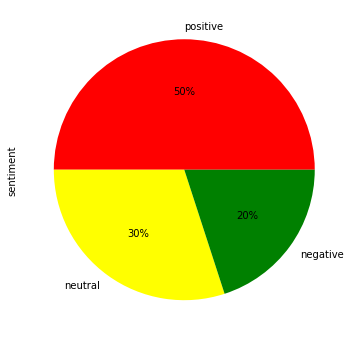

In [74]:

#Using finction to understand the input data
def pie_plot():
  file_data.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])
  return

pie_plot()

In [82]:
#Code to clean the input Reviews data
reviews = file_data.Total_Reviews.values.tolist()
review_tokens = list(tokenization(reviews))

reviews_nostops = stopwords_removal(review_tokens)

review_lemmas = [' '.join(each) for each in reviews_lemmatization(review_tokens, allowed_pos=['NOUN', 'ADJ', 'VERB', 'ADV'])]
print(review_lemmas)


['person see hype claim masterpiece overreact overblown excitement joker base film think look solid good even bit too pretentious trailer here say incredibly wrong massive achievement cinema extremely rare day age cgi nonsense reboot somewhat reboot sort standalone origin tale impeccable start finish echo resemblance good comic_strip past joaquin bleed sweat cry drop magnificently dedicated performance heath ledger would proud undoubtedly great acting performance directing writing slickly brilliant bleak setting tone palpable when film place blow away audience member awestruck witness film could still transport character world very existence believe hype go revere transcend masterpiece', 'once movie come truly make impact joaquin performance scenography brilliance grotesque haunting hard watch time so mesmerize win blink eye watch tragic seriously funny moment emotional rollercoaster sometimes multiple emotion pop same time far typical action riddle predictable super hero movie proper 

'features = file_data.iloc[:,0].values\nlabels = file_data.iloc[:,1].values\n\nprint(features)\nprint(labels)'

In [0]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

#Using function to calculate document term weights using TFidfVectorizer in scikit
def tf_idf(clean_reviews):
  vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
  clean_reviews = vectorizer.fit_transform(clean_reviews).toarray()
  return clean_reviews

tf_idf_reviews = tf_idf(review_lemmas)

# **In above code, term document frequencies are calculated for clea reviews using scikit **

In [0]:
from sklearn.model_selection import train_test_split

#Splitting data into train ,test data and also into input and output data 
X_train, X_test, y_train, y_test = train_test_split(tf_idf_reviews, labels, test_size=0.2, random_state=0)


# **In the above code, data set is divided into 80% train data and 20% test data using train_test_split method from scikit **

In [0]:
from sklearn.preprocessing import StandardScaler

#USing function to normalize the input rows among all target class labels 
def normalizeInput(X_train,X_text):
  scaler = StandardScaler()
  scaler.fit(X_train)
  train_X= scaler.transform(X_train)
  text_X = scaler.transform(X_text)
  return train_X,text_X

train_X , test_X = normalizeInput(X_train,X_test)

# **Since, our dataset is imbalanced between all the classes, we standardize the inputs for all class labels in train and test data **

In [127]:
from sklearn.tree import DecisionTreeClassifier

#Using functions to build and train the Decision Tree Classifier model
def DecisionTreeClassification(x_train,y_train,x_test):
    classifier = DecisionTreeClassifier()
    classifier.fit(x_train, y_train)
    return classifier,classifier.predict(x_test)

#Calling above function to train and predict test output data
classifier_model1,predicted_y1 = DecisionTreeClassification(train_X,y_train,test_X)

#Printing Predicted values

print("Actual and predicted Sentiment labels in Test Data")
class_data1 = panda.DataFrame({'Actual_Sentiment':y_test,'Predicted_Sentiment': predicted_y1})
class_data1.head(30)


Actual and predicted Sentiment labels in Test Data


,Actual_Sentiment,Predicted_Sentiment
0,positive,positive
1,positive,positive
2,neutral,positive
3,positive,positive
4,neutral,neutral
5,positive,positive
6,negative,neutral
7,negative,negative
8,neutral,negative
9,positive,positive


# **In above code, the supervised Decision Tree Regression is built and fitted with train data and predicted the output labels for test data **

In [128]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#printing classification report , accuarcy and confusion matrix for model 1 Decison Tree Classifier model

print("Confusion Matrix for above Decison Tree Classifier model: \n",confusion_matrix(y_test,predicted_y1))
print("\nClassification report for above Decison Tree Classifier model: \n",classification_report(y_test,predicted_y1))
print("\nAccuracy of above Decison Tree Classifier model: ",accuracy_score(y_test, predicted_y1))

Confusion Matrix for above Decison Tree Classifier model: 
 [[2 2 0]
 [1 1 6]
 [0 0 8]]

Classification report for above Decison Tree Classifier model: 
               precision    recall  f1-score   support

    negative       0.67      0.50      0.57         4
     neutral       0.33      0.12      0.18         8
    positive       0.57      1.00      0.73         8

    accuracy                           0.55        20
   macro avg       0.52      0.54      0.49        20
weighted avg       0.50      0.55      0.48        20


Accuracy of above Decison Tree Classifier model:  0.55



# From above, accuracy of the supervised Decision Tree Classifier model is (0.55) 55%

##From Classification matrix:
##precison for negative sentiment predictiosn is 67% with supoort of 4 cases
##precison for neutral sentiment predictiosn is only 33% with support of 8 cases
##precison for positive sentiment predictiosn is 57% with supoort of 8 cases

In [124]:
from sklearn.ensemble import RandomForestClassifier

#Using functions to build and train the RandomForest Classifier model
def RanForClassifier(x_train,y_train,x_test):
    classifier = RandomForestClassifier(n_estimators=200, random_state=0)
    classifier.fit(x_train, y_train)
    return classifier,classifier.predict(x_test)

#Calling above function to train and predict test output data
classifier_model2,predicted_y2 = RanForClassifier(train_X,y_train,test_X)

#Printing Predicted values
print("Actual and predicted Sentiment labels in Test Data using Random Forest Classification")
class_data2 = panda.DataFrame({'Actual_Sentiment':y_test,'Predicted_Sentiment': predicted_y2})
class_data2.head(30)


Actual and predicted Sentiment labels in Test Data using Random Forest Classification


,Actual_Sentiment,Predicted_Sentiment
0,positive,positive
1,positive,positive
2,neutral,positive
3,positive,positive
4,neutral,neutral
5,positive,positive
6,negative,positive
7,negative,negative
8,neutral,negative
9,positive,positive


In [129]:
#printing classification report , accuarcy and confusion matrix for model 2 Random Forest Classifier model

print("Confusion Matrix for above Random Forest Classifier model: \n",confusion_matrix(y_test,predicted_y2))
print("\nClassification report for above Random Forest Classifier model: \n",classification_report(y_test,predicted_y2))
print("\nAccuracy of above Random Forest Classifier model: ",accuracy_score(y_test, predicted_y2))

Confusion Matrix for above Random Forest Classifier model: 
 [[1 1 2]
 [1 1 6]
 [0 0 8]]

Classification report for above Random Forest Classifier model: 
               precision    recall  f1-score   support

    negative       0.50      0.25      0.33         4
     neutral       0.50      0.12      0.20         8
    positive       0.50      1.00      0.67         8

    accuracy                           0.50        20
   macro avg       0.50      0.46      0.40        20
weighted avg       0.50      0.50      0.41        20


Accuracy of above Random Forest Classifier model:  0.5


# From above, accuracy of the supervised Random Forest Classifier model is (0.5) 50%

##From Classification matrix:
##precison for negative sentiment precision is 50% with supoort of 4 cases
##precison for neutral sentiment precision is greater than before model with 50% using support of 8 cases
##precison for positive sentiment precision is 50% with supoort of 8 cases

##From the Accuracy score, Confusion Marix and classification Report we can say that model 1 Decision Tree Classification is relatively better for classification of unknown review sentiment.  

# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/INFO5731_Spring2020/blob/master/Assignments/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [15]:
# Write your code here
import matplotlib.pyplot as plt
import seaborn as sns

#Using functions to read data from csv file
def readingCSV(filePath):
    filedata = panda.read_csv(filePath)
    return filedata

#calling above function to read csv data with a file path
file_path = "https://raw.githubusercontent.com/RadhavaramHarika/Harika_INFO5731_Spring2020/master/train_q3.csv"
train_data = readingCSV(file_path) 

#printing the results of csv data reading
train_data.head(10)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [16]:
#Using functions to verify missing values in the dataset
def verifyMissingValuesInData(fileData):
  panda.set_option('display.max_rows', None)
  print(fileData.isnull().sum())
  
  return

def cleanData(columnList,fileData):
  fileData[columnList]=fileData[columnList].replace(nump.NaN,0)
  return fileData

#Calling above function to verify missing values and print results
print("Verifying Missing values in train dataset: \n")
verifyMissingValuesInData(train_data)

columns_clean = ['LotFrontage','Alley','BsmtQual','BsmtCond','BsmtExposure',
                 'BsmtFinType1','Electrical','BsmtFinType2','FireplaceQu','GarageType',
                 'GarageYrBlt','GarageFinish','GarageQual','GarageCond',
                 'PoolQC','Fence','MiscFeature','MasVnrType','MasVnrArea']
cleanData(columns_clean,train_data)
print("Verifying Missing values in train dataset after cleaning: \n")
verifyMissingValuesInData(train_data)



Verifying Missing values in train dataset: 

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF 

# **Above code to verify missing values and clean them in train data.**

In [17]:
#Using functions to describe the dataset
def descData(fileData,name):
    print("Dimension of the "+name+" dataset: \n",fileData.shape)
    print("\nData Types of the "+name+" dataset: \n",fileData.dtypes)
    print("\nView of the first 10 records of "+name+" dataset: \n",fileData.head(10))
    print("\nSummary of the "+name+" dataset: \n",fileData.describe())
    return

#Calling above function to print dataset description
descData(train_data,'train')

Dimension of the train dataset: 
 (1460, 81)

Data Types of the train dataset: 
 Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         

# **Above code is to describe train data and we can observe categorical columns in this dataset **

In [18]:
#Using functions to convert every categorical column from the dataset into numeric 
def convertCatIntoNumeric(fileData):
  cat_columns = list(fileData.select_dtypes(['object']).columns)
  print(cat_columns)
  fileData[cat_columns] = fileData[cat_columns].apply(lambda x: x.astype('category'))
  fileData[cat_columns] = fileData[cat_columns].apply(lambda x: x.cat.codes)
  return fileData

#Calling above function to convert categorical column to numeric
convertCatIntoNumeric(train_data)

#Againg calling above function to describe datframe columns after changing categorical to numeric in preprocessing
descData(train_data,'train')

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Dimension of the train dataset: 
 (1460, 81)

Data Types of the train dataset: 
 Id                 int64
MSSubClass         int64
MSZoning            int8
LotFrontage      float64
LotArea            int64
Street              int8
Alley               int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1    

# **Above code converts categorical columns to numerical for Regression analysis**

In [19]:
test_path = "https://raw.githubusercontent.com/RadhavaramHarika/Harika_INFO5731_Spring2020/master/test_q3.csv"
test_data = readingCSV(test_path) 

#printing the results of csv data reading
test_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,

In [30]:
#Calling above function to verify missing values and print results
print("Verifying Missing values in test dataset: \n")
verifyMissingValuesInData(test_data) 

columns_clean = ['MSZoning','LotFrontage','Alley','Utilities','Exterior1st','Exterior2nd','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                  'BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                 'BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','FireplaceQu','GarageType',
                 'GarageYrBlt','GarageFinish','GarageQual','GarageCond','GarageArea','GarageCars',
                 'PoolQC','Fence','MiscFeature','SaleType','MasVnrArea']
cleanData(columns_clean,test_data)
print("Verifying Missing values in test dataset after cleaning: \n")
verifyMissingValuesInData(test_data)

Verifying Missing values in test dataset: 

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBa

# **above code is verify the missing values in test data and cleans them.**

In [31]:
#Calling above function to print dataset description
descData(test_data,'test')

Dimension of the test dataset: 
 (1459, 80)

Data Types of the test dataset: 
 Id                 int64
MSSubClass         int64
MSZoning            int8
LotFrontage      float64
LotArea            int64
Street              int8
Alley               int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1          int8
Condition2          int8
BldgType            int8
HouseStyle          int8
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle           int8
RoofMatl            int8
Exterior1st         int8
Exterior2nd         int8
MasVnrType          int8
MasVnrArea       float64
ExterQual           int8
ExterCond           int8
Foundation          int8
BsmtQual            int8
BsmtCond            int8
BsmtExposure        int8
BsmtFinType1        int8
BsmtFinSF1       float64
BsmtFinType2        int8
BsmtFinSF2       floa

# **above code is describe test data and this dataset also has categorical columns which needs to be converted to numerical one fo rregression analysis**

In [32]:
#Calling above function to convert categorical column to numeric
convertCatIntoNumeric(test_data)

#Againg calling above function to describe datframe columns after changing categorical to numeric in preprocessing
descData(test_data,'test')

[]
Dimension of the test dataset: 
 (1459, 80)

Data Types of the test dataset: 
 Id                 int64
MSSubClass         int64
MSZoning            int8
LotFrontage      float64
LotArea            int64
Street              int8
Alley               int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1          int8
Condition2          int8
BldgType            int8
HouseStyle          int8
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle           int8
RoofMatl            int8
Exterior1st         int8
Exterior2nd         int8
MasVnrType          int8
MasVnrArea       float64
ExterQual           int8
ExterCond           int8
Foundation          int8
BsmtQual            int8
BsmtCond            int8
BsmtExposure        int8
BsmtFinType1        int8
BsmtFinSF1       float64
BsmtFinType2        int8
BsmtFinSF2       f

# `**above code to convert categorical columns to numeric one**`

In [33]:
#Calculating pearson Correlation coefficients for target variable with all input variables
correlation = train_data.corr(method='pearson')
panda.set_option('display.max_columns', None)
print(correlation['SalePrice'])

Id              -0.021917
MSSubClass      -0.084284
MSZoning        -0.166872
LotFrontage      0.209624
LotArea          0.263843
Street           0.041036
Alley           -0.092607
LotShape        -0.255580
LandContour      0.015453
Utilities       -0.014314
LotConfig       -0.067396
LandSlope        0.051152
Neighborhood     0.210851
Condition1       0.091155
Condition2       0.007513
BldgType        -0.085591
HouseStyle       0.180163
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
RoofStyle        0.222405
RoofMatl         0.132383
Exterior1st      0.103551
Exterior2nd      0.103766
MasVnrType      -0.000488
MasVnrArea       0.472614
ExterQual       -0.636884
ExterCond        0.117303
Foundation       0.382479
BsmtQual        -0.438881
BsmtCond         0.147367
BsmtExposure    -0.193079
BsmtFinType1    -0.013233
BsmtFinSF1       0.386420
BsmtFinType2     0.130814
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF 

# **above code calculates and shows correlation coefficients for target 'SalePrice' variable with all input variable.**

# **From here, based on these correlation coefficients 15 predictor variables are selected to predict target variable using linear regression **

In [34]:
#Using functions to split dataset into input,output and to convert into array
def splittingInpOut(fileData):
    ar_data = nump.array(fileData)
    X = fileData[['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','ExterQual',
                  'BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath',
                  'KitchenQual','TotRmsAbvGrd','Fireplaces','FireplaceQu',
                  'GarageCars','GarageArea']].values
    y = fileData['SalePrice'].values
    return (ar_data,X,y)

#Calling above function to split train data and printing its results
train_ar = splittingInpOut(train_data)[0]
train_X_data = splittingInpOut(train_data)[1]
train_y_data = splittingInpOut(train_data)[2]

print("Array of the dataset: \n",train_ar)
print("\nTrain Input data X: \n",train_X_data)
print("\nTrain Output data Y: \n",train_y_data)

Array of the dataset: 
 [[1.00000e+00 6.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  2.08500e+05]
 [2.00000e+00 2.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  1.81500e+05]
 [3.00000e+00 6.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  2.23500e+05]
 ...
 [1.45800e+03 7.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  2.66500e+05]
 [1.45900e+03 2.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  1.42125e+05]
 [1.46000e+03 2.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  1.47500e+05]]

Train Input data X: 
 [[7.000e+00 2.003e+03 2.003e+03 ... 0.000e+00 2.000e+00 5.480e+02]
 [6.000e+00 1.976e+03 1.976e+03 ... 5.000e+00 2.000e+00 4.600e+02]
 [7.000e+00 2.001e+03 2.002e+03 ... 5.000e+00 2.000e+00 6.080e+02]
 ...
 [7.000e+00 1.941e+03 2.006e+03 ... 3.000e+00 1.000e+00 2.520e+02]
 [5.000e+00 1.950e+03 1.996e+03 ... 0.000e+00 1.000e+00 2.400e+02]
 [5.000e+00 1.965e+03 1.965e+03 ... 0.000e+00 1.000e+00 2.760e+02]]

Train Output data Y: 
 [208500 181500 223500 ... 266

# **above splits the train data into input variables and output variable 'SalePrice'**

In [35]:
#Calling above function to split train data and printing its results
test_ar = ar_data = nump.array(test_data)
test_X_data = test_data[['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','ExterQual',
                  'BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath',
                  'KitchenQual','TotRmsAbvGrd','Fireplaces','FireplaceQu',
                  'GarageCars','GarageArea']].values

print("Array of the Test dataset: \n",test_ar)
print("\nTest Input data X: \n",test_X_data)

Array of the Test dataset: 
 [[1.461e+03 2.000e+01 2.000e+00 ... 2.010e+03 9.000e+00 4.000e+00]
 [1.462e+03 2.000e+01 3.000e+00 ... 2.010e+03 9.000e+00 4.000e+00]
 [1.463e+03 6.000e+01 3.000e+00 ... 2.010e+03 9.000e+00 4.000e+00]
 ...
 [2.917e+03 2.000e+01 3.000e+00 ... 2.006e+03 9.000e+00 0.000e+00]
 [2.918e+03 8.500e+01 3.000e+00 ... 2.006e+03 9.000e+00 4.000e+00]
 [2.919e+03 6.000e+01 3.000e+00 ... 2.006e+03 9.000e+00 4.000e+00]]

Test Input data X: 
 [[5.000e+00 1.961e+03 1.961e+03 ... 0.000e+00 1.000e+00 7.300e+02]
 [6.000e+00 1.958e+03 1.958e+03 ... 0.000e+00 1.000e+00 3.120e+02]
 [5.000e+00 1.997e+03 1.998e+03 ... 5.000e+00 2.000e+00 4.820e+02]
 ...
 [5.000e+00 1.960e+03 1.996e+03 ... 5.000e+00 2.000e+00 5.760e+02]
 [5.000e+00 1.992e+03 1.992e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [7.000e+00 1.993e+03 1.994e+03 ... 5.000e+00 3.000e+00 6.500e+02]]


# **since test data doesnot have target variable, above code converts dataset is taken as input test data**

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#Using functions to build and train the linear regression model
def linRegression(x_train,y_train,x_test):
    regressor = LinearRegression()  
    regressor.fit(x_train, y_train)
    return regressor,regressor.predict(x_test)

#Calling above function to train and predict test output data
model,predicted_y = linRegression(train_X_data,train_y_data,test_X_data)

#Printing Predicted values

print("Predicted Sale Prices for Test Data")
data = panda.DataFrame({'Predicted_SalePrice': predicted_y})
reg_data = data.head(30)
reg_data

Predicted Sale Prices for Test Data


,Predicted_SalePrice
0,92425.047319
1,150006.078948
2,156604.852541
3,183330.630365
4,195296.844255
5,154935.845251
6,157275.833048
7,153412.283157
8,186835.542072
9,96031.559549


# **above builds Linear Regression model and fits the model with train data and predicts output for test data**

In [37]:
#Using score() to get r-square value of the linear regression model
print("R-Square value of above linear Regression model : ",model.score(train_X_data,train_y_data))

R-Square value of above linear Regression model :  0.8080713883609486


# **Rquare value if this regression analysis is 0.8080(80.80%) i.e, 80.80 percent of variation target 'SalePrice' is explained by input predictor variables.**